<a href="https://colab.research.google.com/github/dagyeom23658/project_dayeom_chatbot/blob/main/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EB%A5%BC_%EC%B1%97%EB%B4%87(%EC%84%9C%EB%B8%8C%EC%9B%8C%EB%93%9C%ED%86%A0%EC%BB%A4%EB%82%98%EC%9D%B4%EC%A0%80).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 4.2 MB/s 
     |████████████████████████████████| 448 kB 39.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


# 트랜스포머를 이용한 한국어 챗봇

 2017년 구글이 발표한 논문인 "Attention is all you need"에서 나온 모델로 기존의 seq2seq의 구조인 인코더-디코더를 따르면서도, 논문의 이름처럼 어텐션(Attention)만으로 구현한 모델

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 포지셔널 인코딩(Positional Encoding)
- 기존 RNN은 단어의 위치에 따라 단어를 순차적으로 입력받아 처리하므로, 각 단어의 위치정보를 가질 수 있었다.

- 트랜스포머는 단어를 순차입력받는 방식이 아니므로, 단어의 위치정보를 얻기위해 각 단어의 임베딩 벡터에 위치정보를 더해 모델의 입력으로 사용하게 된다. 

- 트랜스포머의 입력은 순서 정보가 고려된 임베딩 벡터이다.

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## 인코더(Encoder) - 셀프어텐션
- 셀프 어텐션을 병렬적으로 사용
- 어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구합니다. 그리고 구해낸 이 유사도를 가중치로 하여 키와 맵핑되어있는 각각의 '값(Value)'에 반영. 그리고 유사도가 반영된 '값(Value)'을 모두 가중합하여 리턴

- 셀프 어텐션은 인코더의 초기 입력인 
의 차원을 가지는 단어 벡터들을 사용하여 셀프 어텐션을 수행하는 것이 아니라 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거칩니다. 이때 이 Q벡터, K벡터, V벡터들은 초기 입력인 
의 차원을 가지는 단어 벡터들보다 더 작은 차원을 가지는데, 논문에서는 
=512의 차원을 가졌던 각 단어 벡터들을 64의 차원을 가지는 Q벡터, K벡터, V벡터로 변환하였습니다.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

## 멀티 헤드 어텐션(Multi-head Attention)

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  # 패딩 마스크(두번째 서브층)
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


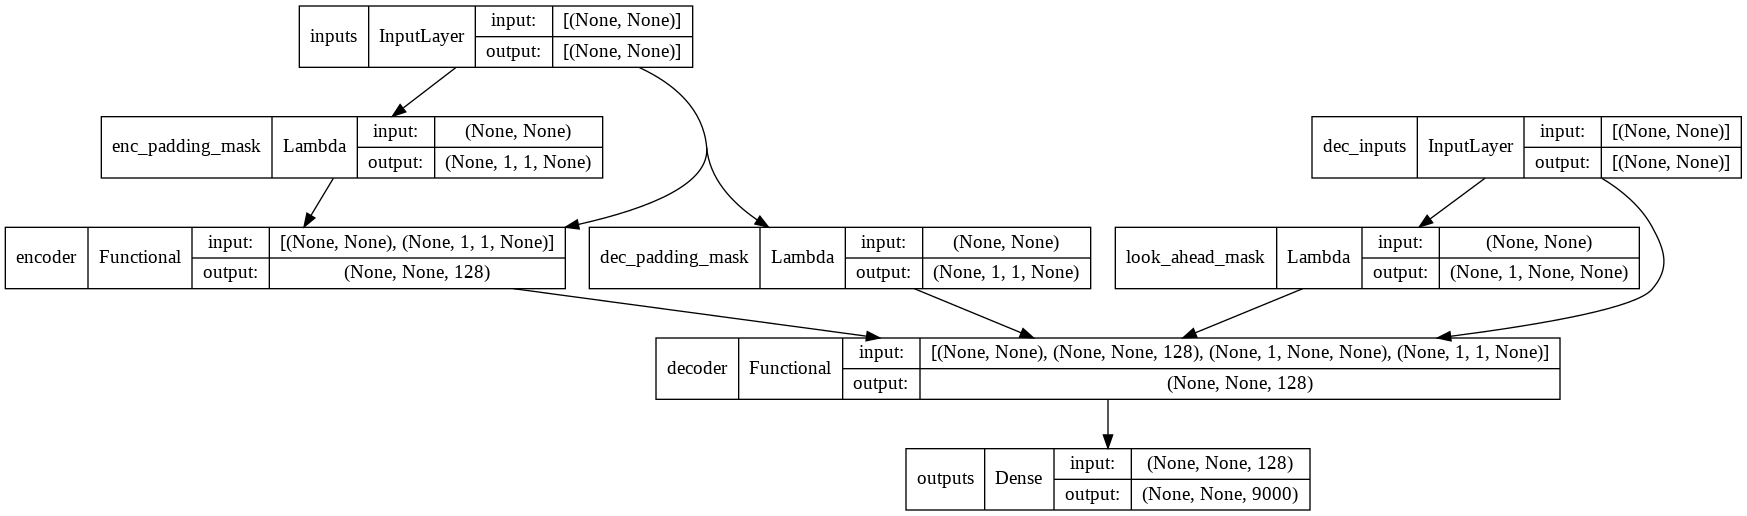

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 3,
    dff = 512,  # 디코더의 포지션 와이즈 피드 포워드 신경망의 은닉층 
    d_model = 128,  #인코더와 디코더의 입, 출력의 차원
    num_heads = 4,  #멀티-헤드 어텐션에서 병렬적으로 사용할 헤드의 수 
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

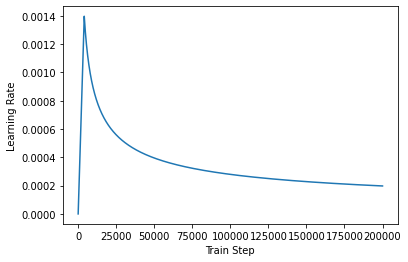

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 파일 불러오기

In [ ]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Training.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [ ]:
val_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Validation.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [ ]:
stop_words1 = pd.read_excel('/content/drive/MyDrive/프로젝트1/ko_stop_words.xlsx',header=None) 

In [ ]:
stop_words2 = pd.read_excel('/content/drive/MyDrive/프로젝트1/ko_stop_words2.xlsx', header=None)  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
stop_words2.head()

,0,1,2
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898


In [ ]:
print(stop_words1.shape)
print(stop_words1.isna().sum())

stop1 = stop_words1.iloc[:,0].to_frame().values.tolist()
stop2 = stop_words1.iloc[:,1].to_frame().values.tolist()
stop3 = stop_words1.iloc[:,2].to_frame().dropna().values.tolist()

# 2차원리스트 -> 1차원리스트로 변환 https://codechacha.com/ko/python-flatten-list/

stop = stop1+stop2+stop3
print(len(stop))

stop2=sum(stop,[])
print(len(stop2))

stop_im = stop_words2[0].to_list()
stop_word=stop2 + stop_im
print(len(stop_word))

stop_words=set(stop_word)
print(stop_words)

(250, 3)
0     0
1     0
2    73
dtype: int64
677
677
777
{'결과에 이르다', '하면서', '둘', '크', '오', '이리하여', '몇', '설사', '우리들', '어떠한', '다시', '아이구', '비록', '이래', '퉤', '솨', '나', '데', '하기 위하여', '비길수 없다', '어찌', '그러므로', '버금', '오히려', '할때', '부터', '콸콸', '한다면', '어째서', '기대여', '하느니', '받', '따라서', '진짜로', '이러이러하다', '하지 않도록', '저희', '할줄알다', '이렇', '지', '전후', '에 가서', '실로', '일것이다', '따위', '만큼', '헉', '까악', '무엇', '일반적으로', '대하', '무릎쓰고', '이천육', '좍좍', '때', '사회', '부류의 사람들', '거의', '게우다', '하여야', '때문', '아야', '그런 까닭에', '더', '힘입어', '그들', '말할것도 없고', '두번째로', '삐걱', '하마터면', '어떻', '더불어', '여전히', '가까스로', '동시에', '봐라', '너희들', '연관되다', '같', '관하여', '마음대로', '이외에도', '아무도', '그에 따르는', '해도좋다', '붕붕', '이러한', '하지 않는다면', '여보시오', '하게될것이다', '왜', '이렇구나', '각', '아하', '이 정도의', '기준으로', '알았어', '이용하여', '월', '원', '결국', '하곤하였다', '설령', '만일', '사실', '틈타', '언제', '팍', '륙', '휴', '비슷하다', '그러한즉', '어때', '에 대해', '오로지', '하든지', '구체적으로', '요컨대', '입장에서', '구토하다', '이럴정도로', '남들', '어찌됏든', '우리', '더욱이는', '등등', '그리하여', '이 외에', '오자마자', '좀', '조차도', '넷', '하면된다', '일때', '을', '매번', '나오

In [ ]:
stop_words.add(',')
stop_words.add('.')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
train_data['번호']=train_data['번호'].astype('str')

# 앞뒤 공백 처리.
train_data =train_data.apply(lambda x: x.str.strip() , axis = 1)  #https://www.delftstack.com/ko/howto/python-pandas/difference-between-pandas-apply-map-and-applymap/
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [ ]:
# 공백제거
val_data['번호']=val_data['번호'].astype('str')
val_data =val_data.apply(lambda x: x.str.strip() , axis = 1)

In [ ]:
# 확인
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [ ]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 40879


In [ ]:
print(train_data.isnull().sum())

번호            0
연령            0
성별            0
상황키워드         0
신체질환          0
감정_대분류        0
감정_소분류        0
사람문장1         0
시스템응답1        0
사람문장2         0
시스템응답2        0
사람문장3      9820
시스템응답3     9820
사람문장4     39407
시스템응답4    39517
dtype: int64


# 전처리 : 서브워드 토크나이저

In [ ]:
# 구두점 처리
questions = []
for sentence in train_data['사람문장1']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [ ]:
answers = []
for sentence in train_data['시스템응답1']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [ ]:
print(questions[:5])
print(answers[:5])

['아내가 드디어 출산하게 되어서 정말 신이 나 .', '당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야 .', '고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워 .', '재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 .  너무 행복해 .', '빚을 드디어 다 갚게 되어서 이제야 안도감이 들어 .']
['아내분이 출산을 하시는군요 .  정말 축하드려요 .', '약 종류가 많아 번거로우시겠어요 .', '고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요 .', '재취업 후 첫 월급이라 정말 기쁘시겠어요 .', '기분 좋으시겠어요 .  앞으로는 어떻게 하실 생각이신가요 ?']


# 단어 집합 생성
- 서브워드 단위로 토큰을 분리하는 토크나이저로 학습 데이터로부터 학습하여 서브워드로 구성된 단어 집합을 생성

In [ ]:
pip install tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds
import urllib.request

In [ ]:
# 서브워드텍스트인코더를 사용하여 질문, 답변 데이터로부터 단어 집합(Vocabulary) 생성
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)  #tfds.features.text.SubwordTextEncoder.build_from_corpus

In [ ]:
tokenizer.vocab_size 

8099

In [ ]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

# 패딩에 사용될 0번 토큰부터 마지막 토큰인 8,179번 토큰까지의 개수를 카운트하면 단어 집합의 크기는 8,180개

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8099]
종료 토큰 번호 : [8100]
단어 집합의 크기 : 8101


# 정수 인코딩과 패딩

In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('임의의 질문 샘플을 정수 인코딩 : {}'.format(tokenizer.encode(questions[20])))

임의의 질문 샘플을 정수 인코딩 : [4850, 2051, 2113, 1497, 17, 4, 198, 3326, 1233, 2, 37, 96, 4609, 6754, 3152, 2918, 6, 35, 1]


In [ ]:
print('정수 인코딩 결과를 디코딩 : {}'.format(tokenizer.decode([4850, 2051, 2113, 1497, 17, 4, 198, 3326, 1233, 2, 37, 96, 4609, 6754, 3152, 2918, 6, 35, 1])))

정수 인코딩 결과를 디코딩 : 지난주에 주식이 폭락해서 너무 큰 손해를 봤어 .  어떻게 해야 좋을지 모르겠고 정신이 나갈 것 같아 .


In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 .decode() 테스트해보기
# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [4850, 2051, 2113, 1497, 17, 4, 198, 3326, 1233, 2, 37, 96, 4609, 6754, 3152, 2918, 6, 35, 1]
기존 문장: 지난주에 주식이 폭락해서 너무 큰 손해를 봤어 .  어떻게 해야 좋을지 모르겠고 정신이 나갈 것 같아 .


In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

4850 ----> 지난주에 
2051 ----> 주식이 
2113 ----> 폭
1497 ----> 락
17 ----> 해서 
4 ----> 너무 
198 ----> 큰 
3326 ----> 손해를 
1233 ----> 봤어
2 ---->  .  
37 ----> 어떻게 
96 ----> 해야 
4609 ----> 좋을지 
6754 ----> 모르겠고 
3152 ----> 정신이 
2918 ----> 나갈 
6 ----> 것 
35 ----> 같아
1 ---->  .


In [ ]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (40879, 40)
답변 데이터의 크기(shape) : (40879, 40)


In [ ]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8099   70  373 4035   14  256   19  894   34    1 8100    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8099 1246 1983  500    2   19  519    1 8100    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


# 인코더와 디코더의 입력, 그리고 레이블 만들기.

In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8099 1246 1983  500    2   19  519    1 8100    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8099 1246 1983  500    2   19  519    1 8100    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[1246 1983  500    2   19  519    1 8100    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


# 트랜스포머 만들기

(1, 8101, 256)
(1, 8101, 256)


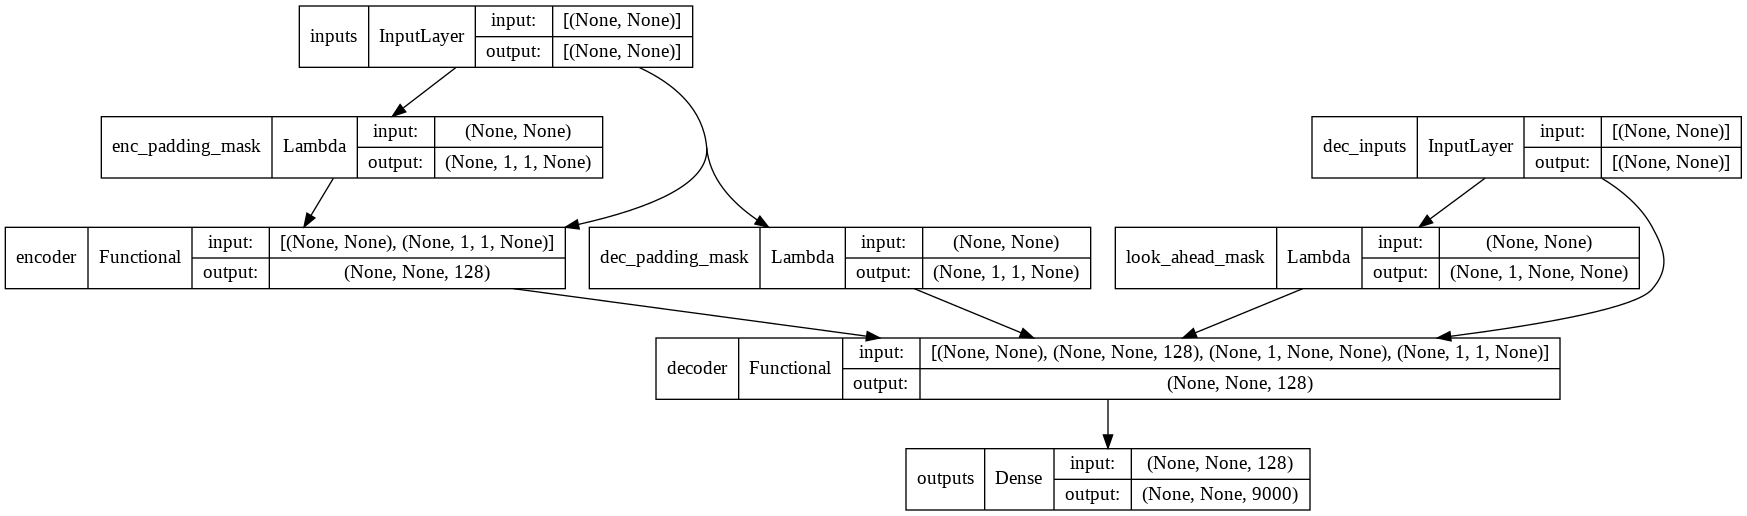

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

tf.keras.utils.plot_model(
    small_transformer, to_file='model.png', show_shapes=True)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS)  #왜 accuracy로는 측정되지 않는가?

Epoch 1/50
639/639 [==============================] - 96s 117ms/step - loss: 2.0108 - accuracy: 0.0393
Epoch 2/50
639/639 [==============================] - 76s 118ms/step - loss: 1.4710 - accuracy: 0.0740
Epoch 3/50
639/639 [==============================] - 73s 115ms/step - loss: 1.2435 - accuracy: 0.0886
Epoch 4/50
639/639 [==============================] - 73s 114ms/step - loss: 1.0756 - accuracy: 0.1005
Epoch 5/50
639/639 [==============================] - 73s 114ms/step - loss: 0.9407 - accuracy: 0.1101
Epoch 6/50
639/639 [==============================] - 73s 114ms/step - loss: 0.8368 - accuracy: 0.1189
Epoch 7/50
639/639 [==============================] - 73s 114ms/step - loss: 0.7497 - accuracy: 0.1283
Epoch 8/50
639/639 [==============================] - 73s 114ms/step - loss: 0.6468 - accuracy: 0.1415
Epoch 9/50
639/639 [==============================] - 72s 113ms/step - loss: 0.5555 - accuracy: 0.1549
Epoch 10/50
639/639 [==============================] - 72s 113ms/step - l

# 챗봇 평가

pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-uv5s21id
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-uv5s21id
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=e3820d4a2ad3370cafba2a52b52f384a4448cca52eb3a0849b5d9a7b5ef1f77d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ga7358ap/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [ ]:
from hanspell import spell_checker

In [ ]:
def preprocess_sentence(sentence):
  # 단어와 구두점 사이에 공백 추가.
  # ex) 12시 땡! -> 12시 땡 !
  spelled_sent = spell_checker.check(sentence)    # 챗봇에 단어를 입력할 때는 비문법이 많으므로 문법을 맞춰주고 띄어쓰기를 시켜준다. 이걸 추가하니까 성능이 훨씬 좋아졌다.
  hanspell_sent = spelled_sent.checked
  sentence = re.sub(r"([?.!,])", r" \1 ", hanspell_sent)
  sentence = sentence.strip()
  return sentence

In [ ]:
def evaluate(sentence):
  # 입력 문장에 대한 전처리
  sentence = preprocess_sentence(sentence)

  # 입력 문장에 시작 토큰과 종료 토큰을 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 현재 시점의 예측 단어를 output(출력)에 연결한다.
    # output은 for문의 다음 루프에서 디코더의 입력이 된다.
    output = tf.concat([output, predicted_id], axis=-1)

  # 단어 예측이 모두 끝났다면 output을 리턴.
  return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence):
  prediction = evaluate(sentence)

  # prediction == 디코더가 리턴한 챗봇의 대답에 해당하는 정수 시퀀스
  # tokenizer.decode()를 통해 정수 시퀀스를 문자열로 디코딩.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
# 감성별로 분류해서 모델을 각자 따로 만들어야 겠다. 그래서, 감정을 먼저 예측하고, 그게 알맞은 모델로 배치되서 나올 수 있도록 해야겠다. 
# 챗봇 특성상, 띄어쓰기를 안하거나 맞춤법을 맞추지 못해도 반영이 되어야 하는데,,, 그게 반영이 안된다. 사용자입력시퀀스에서 띄어쓰기가 되도록 전처리를 다른 방법으로 해야할 것 같다. # 사용자입력시퀀스에서만 하면 될 듯. 
# 데이터의 언어가 너무 정형화되어 있다. 이름만 감성데이터셋이지, 감성이 별로 반영되지 않은 것 같다. 
# 챗봇이랑은 '은밀하게' 얘기할텐데, 누가 저렇게 정형화된 언어로 바람직하게 말한단 말인가.
# 하여튼,, 데이터와 전처리가 정말 중요한 것 같다. 

# 이어나가면서 말하는 건 어떻게 구현하지?

# 다른 말투로 말하는건 어떻게 구현할까... 

# 첫번째 문장으로 감성분석을 해주고... 

# 불용어 제거가 필요하다. 

In [ ]:
output = predict("에고 짜증나")   # 에고 와 같은 의성어는 전혀 반영하지 못한다. 학습 데이터에 없었던 것 같다. 

Input: 에고 짜증나
Output: 에짜증이 나시는군요 .  무슨 일이 있으셨나요 ?


In [ ]:
output = predict("누군가 내 몸에 빙의했다")   # 이런건 아예 못알아듣는다. 

Input: 누군가 내 몸에 빙의했다
Output: 건강이 몸이 모습을 보며 드시겠군요 .


In [ ]:
output = predict("오징어도 사랑이 되나요")   # 이런 부분은 데이터셋의 문제라고 하겠다. 

Input: 오징어도 사랑이 되나요
Output: 오랜교에서 사랑이 있는 것 같아 속상하신가 봐요 .


In [ ]:
output = predict("연애하고싶다")   # 챗봇 특성상, 띄어쓰기를 안하거나 맞춤법을 맞추지 못해도 반영이 되어야 하는데,,, 그게 반영이 안된다. 

Input: 연애하고싶다
Output: 어떤 분과 연애를 하고 싶으신가요 ?


In [ ]:
output = predict("연애하고 싶다")  # 띄어쓰기가 잘 되어 있으니 잘 알아듣는다. 이거는 언어 전처리에 문제가 있어보인다. 

Input: 연애하고 싶다
Output: 어떤 분과 연애를 하고 싶으신가요 ?


In [ ]:
output = predict("게임하자")  # 이런 건 데이터 부족이라고밖에는 못하겠다. 

Input: 게임하자
Output: 게임기가 막신 걸 알고 마음이 쓰이셨군요 .


In [ ]:
output = predict("사랑해요")   # 하 진짜루 ㅠ ㅠ

Input: 사랑해요
Output: 요가를 하시면서 기분이 좋으신가 봐요 .


In [ ]:
output = predict("그를 너무 사랑해")   # 대명사 파악안됌

Input: 그를 너무 사랑해
Output: 무슨 일이 있으신가요 ?  자세히 말해 주시겠어요 ?


In [ ]:
output = predict("오늘 너무 행복한 날이였어.")

Input: 오늘 너무 행복한 날이였어.
Output: 오늘 무슨 일이 있으셨나 봐요 .


In [ ]:
output = predict("내 집을 구입해서 너무 기뻐")

Input: 내 집을 구입해서 너무 기뻐
Output: 집을 구하셨군요 .  기분이 좋으시군요 .


In [ ]:
output = predict("너는 오늘 뭐했니")

Input: 너는 오늘 뭐했니
Output: 무슨 일이 있으셨나요 ?


In [ ]:
output = predict("커피를 너무 많이 마셨더니 잠이 잘 와")

Input: 커피를 너무 많이 마셨더니 잠이 잘 와
Output: 커피를 많이 당황스러우셨겠어요 .


In [ ]:
output = predict("엄청 큰 다이아몬드반지")

Input: 엄청 큰 다이아몬드반지
Output: 큰 아몬의 반영양한 것이 무엇인가요 ?


In [ ]:
output = predict("넌 비아냥거리지 말았으면 좋겠다.")  #데이터셋에 문제가 있는 것 같습니다. 도무지 챗봇에 적합한 데이터셋이라고는 못하겠네요. 데이터셋 교체합니다. 

Input: 넌 비아냥거리지 말았으면 좋겠다.
Output: 댄대에서 비아냥대는 말투에 당황하셨군요 .


In [ ]:
output = predict("나는 네 주인이야! ")

Input: 나는 네 주인이야! 
Output: 무슨 일 있으셨어요 ?


In [ ]:
output = predict("밥도 사고 커피도 사고 운전도 하고 오빠가 다 해")

Input: 밥도 사고 커피도 사고 운전도 하고 오빠가 다 해
Output: 오빠에게 커피 심부름을 시키면 기쁘시겠어요 .


In [ ]:
output = predict("어디갈거야?")

Input: 어디갈거야?
Output: 그렇게 생각하시는 이유가 있나요 ?


In [ ]:
output = predict("오늘 너무 행복해")

Input: 오늘 너무 행복해
Output: 오늘 행복하시다니 너무 행복하시군요 .  무슨 일이 있으셨나요 ?


In [ ]:
output = predict("청혼을 받았거든. 하늘을 날것같아")   # 심지어 악담을 하는 챗봇...

Input: 청혼을 받았거든. 하늘을 날것같아
Output: 청혼을 받아 요 .  든든하시겠어요 .


In [ ]:
# 이정도쯤 되면, Rule-Based 챗봇이 가장 간단하고 성능이 좋을 것 같다는 생각이 듭니다. https://needjarvis.tistory.com/639

In [ ]:
output = predict("ㅋㅋㅋㅋㅋㅋㅋㅋ 삐리뽕빼리뽕 아이돌 에이비식스 기부요정") 

Input: ㅋㅋㅋㅋㅋㅋㅋㅋ 삐리뽕빼리뽕 아이돌 에이비식스 기부요정
Output: 좋은 소식이네요 .  성과만큼 좋은 일 방법으로 전셋있을 거라 하니 기쁘시겠어요 .


In [ ]:
피클로 저장하기 : https://terryvery.tistory.com/63

